In [1]:
from pathlib import Path
import pandas as pd, numpy as np

ROOT = Path().resolve()
P = ROOT / "D:/project=2/Agrigpt/data/processed"
R = ROOT / "reports"

chunks = pd.read_parquet(P/"chunks.parquet")
chunks.head(3)


,chunk_id,doc_id,source,language,section_path,created_at,text,token_count,fields
0,chunk_fd978b1fcd2e,doc_51c8bb4f2c18,bangladesh_agri,bn,Aus Rice(Local: Broadcasted) > Season > Kharif...,2025-09-13T09:22:33Z,ফসল: Aus Rice(Local: Broadcasted) | মৌসুম: Kha...,583,"{""crop_name"": ""Aus Rice(Local: Broadcasted)"", ..."
1,chunk_1608153867a9,doc_51c8bb4f2c18,bangladesh_agri,bn,Sunn Hemp 1 > Season > Kharif 1 | Cotton 1 > S...,2025-09-13T09:22:33Z,ফসল: Sunn Hemp 1 | মৌসুম: Kharif 1 | রোপণ: Mar...,578,"{""crop_name"": ""Sunn Hemp 1"", ""season"": ""Kharif..."
2,chunk_d89f373d8511,doc_51c8bb4f2c18,bangladesh_agri,bn,Guava > Season > Kharif 1 | Date Palm > Season...,2025-09-13T09:22:33Z,ফসল: Guava | মৌসুম: Kharif 1 | রোপণ: April | ব...,588,"{""crop_name"": ""Guava"", ""season"": ""Kharif 1"", ""..."


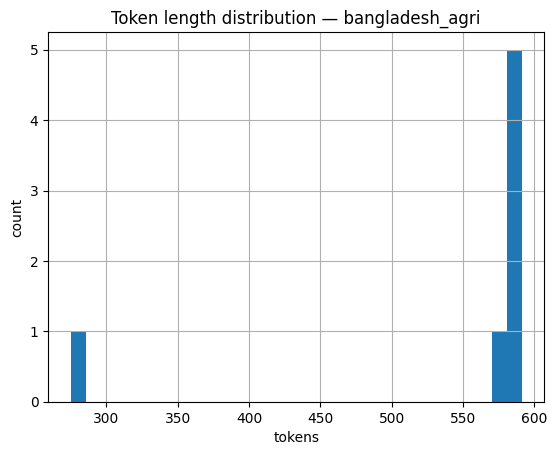

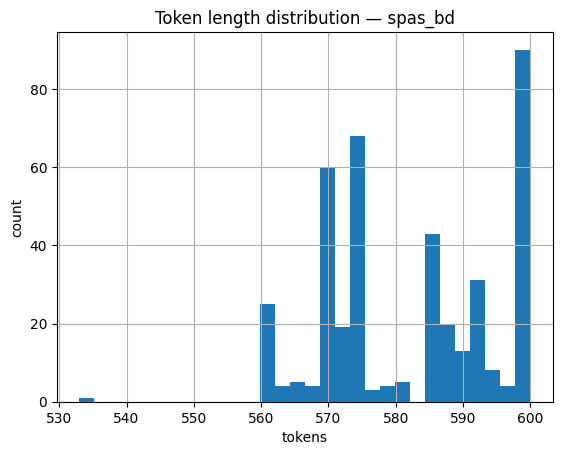

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
bangladesh_agri,7.0,541.571429,117.624908,275.0,580.5,588.0,588.0,591.0
spas_bd,407.0,582.422604,12.934594,533.0,571.0,585.0,593.5,600.0


In [3]:
import matplotlib.pyplot as plt

for src, g in chunks.groupby("source"):
    plt.figure()
    g["token_count"].hist(bins=30)
    plt.title(f"Token length distribution — {src}")
    plt.xlabel("tokens")
    plt.ylabel("count")
    plt.show()

chunks.groupby("source")["token_count"].describe()


In [4]:
def show_examples(src, n=3):
    df = chunks[chunks["source"]==src].head(n)
    for _, row in df.iterrows():
        print("chunk_id:", row["chunk_id"])
        print("section_path:", row["section_path"])
        print("token_count:", row["token_count"])
        print(row["text"][:400], "...\n")

show_examples("bangladesh_agri", n=2)
show_examples("spas_bd", n=2)


chunk_id: chunk_fd978b1fcd2e
section_path: Aus Rice(Local: Broadcasted) > Season > Kharif 1 | Aus Rice(HYV: Transplant) > Season > Kharif 1 | Maize 2 > Season > Kharif 1 | Mungbean 2 > Season > Kharif 1 | Soybean 2 > Season > Kharif 1 | Groundnut 2 > Season > Kharif 1 | Ridge Gourd > Season > Kharif 1 | Indian Spinach(Pui shakh) > Season > Kharif 1 | Kang Kong(Kolomi Shakh) > Season > Kharif 1 | Egg plant > Season > Kharif 1 | Hyacinth Bean > Season > Kharif 1 | Onion 2 > Season > Kharif 1 | Jute(Capsularis) > Season > Kharif 1 | Jute(Olitorius) > Season > Kharif 1 | Jowar > Season > Kharif 1 | Sunn Hemp 1 > Season > Kharif 1 | Cotton 1 > Season > Kharif 1 | Turmeric > Season > Kharif 1 | Beans > Season > Kharif 1 | Ladys Finger > Season > Kharif 1
token_count: 583
ফসল: Aus Rice(Local: Broadcasted) | মৌসুম: Kharif 1 | রোপণ: March | বৃদ্ধি: April to july | কাটাই: Aug | তাপমাত্রা: 12.0–40.0°C | আপেক্ষিক আর্দ্রতা: 85–60% | দেশ: Bangladesh
ফসল: Aus Rice(HYV: Transplant) | মৌসুম: Kharif 1 |

In [5]:
import numpy as np
from sentence_transformers import SentenceTransformer

embs = np.load(P/"chunk_embeds.npy")
chunk_ids = (P/"chunk_ids.txt").read_text(encoding="utf-8").splitlines()

model = SentenceTransformer("intfloat/multilingual-e5-large")
def embed_query(q):
    return model.encode([f"query: {q}"], normalize_embeddings=True)[0].astype(np.float32)

def search(q, k=5):
    qv = embed_query(q)
    sims = embs @ qv  # cosine since normalized
    idx = np.argsort(-sims)[:k]
    return [(chunk_ids[i], float(sims[i])) for i in idx]

hits = search("ধান রোপণের সময় ও আবহাওয়া", k=5)
hits


d:\project=2\Agrigpt\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[('chunk_d7869aab08b4', 0.8420962691307068),
 ('chunk_85562792002e', 0.8410168886184692),
 ('chunk_28e5421e0ff2', 0.8399117588996887),
 ('chunk_b1b4aa1901ea', 0.8398547172546387),
 ('chunk_d96656fc0aee', 0.8396797180175781)]

In [6]:
id_to_text = {row["chunk_id"]: row["text"] for _, row in chunks.iterrows()}
[(cid, score, id_to_text[cid][:200]) for cid, score in hits]


[('chunk_d7869aab08b4',
  0.8420962691307068,
  'ফসল: Beans | জেলা: Gazipur | মৌসুম: Kharif 1 | রোপণ: June | বৃদ্ধি: July to Nov | কাটাই: Nov to April | গড় তাপমাত্রা: 16.0°C | তাপমাত্রা: 10.0–22°C | গড় আর্দ্রতা: 67.5% | আপেক্ষিক আর্দ্রতা: 75–60% | উ'),
 ('chunk_85562792002e',
  0.8410168886184692,
  'ফসল: Danta Shak | জেলা: Gopalganj | মৌসুম: Rabi | রোপণ: March | বৃদ্ধি: April to Aug | কাটাই: Sep | গড় তাপমাত্রা: 25.0°C | তাপমাত্রা: 18.0–32°C | গড় আর্দ্রতা: 80.0% | আপেক্ষিক আর্দ্রতা: 85–75% | উৎপাদ'),
 ('chunk_28e5421e0ff2',
  0.8399117588996887,
  'ফসল: Beans | জেলা: Narayanganj | মৌসুম: Kharif 1 | রোপণ: June | বৃদ্ধি: July to Nov | কাটাই: Nov to April | গড় তাপমাত্রা: 16.0°C | তাপমাত্রা: 10.0–22°C | গড় আর্দ্রতা: 67.5% | আপেক্ষিক আর্দ্রতা: 75–60%'),
 ('chunk_b1b4aa1901ea',
  0.8398547172546387,
  'ফসল: Barbati | জেলা: Sunamganj | মৌসুম: Kharif 2 | রোপণ: Sep | বৃদ্ধি: Oct to Dec | কাটাই: December to April | গড় তাপমাত্রা: 25.0°C | তাপমাত্রা: 20.0–30°C | গড় আর্দ্রতা: 72.5% | আপেক্ষিক আর্দ্